Epoch 0, Accuracy: 2.16%
Epoch 10, Accuracy: 14.09%
Epoch 20, Accuracy: 25.75%
Epoch 30, Accuracy: 44.21%
Epoch 40, Accuracy: 53.51%
Epoch 50, Accuracy: 60.02%
Epoch 60, Accuracy: 63.97%
Epoch 70, Accuracy: 66.77%
Epoch 80, Accuracy: 68.89%
Epoch 90, Accuracy: 70.88%
Epoch 100, Accuracy: 72.56%
Epoch 110, Accuracy: 74.00%
Epoch 120, Accuracy: 75.59%
Epoch 130, Accuracy: 76.93%
Epoch 140, Accuracy: 78.31%
Epoch 150, Accuracy: 79.60%
Epoch 160, Accuracy: 80.86%
Epoch 170, Accuracy: 82.06%
Epoch 180, Accuracy: 83.17%
Epoch 190, Accuracy: 84.09%
Epoch 200, Accuracy: 84.95%
Epoch 210, Accuracy: 85.78%
Epoch 220, Accuracy: 86.49%
Epoch 230, Accuracy: 87.05%
Epoch 240, Accuracy: 87.62%
Epoch 250, Accuracy: 88.21%
Epoch 260, Accuracy: 88.65%
Epoch 270, Accuracy: 89.10%
Epoch 280, Accuracy: 89.51%
Epoch 290, Accuracy: 89.79%
Epoch 300, Accuracy: 90.22%
Epoch 310, Accuracy: 90.59%
Epoch 320, Accuracy: 90.90%
Epoch 330, Accuracy: 91.23%
Epoch 340, Accuracy: 91.37%
Epoch 350, Accuracy: 91.71%
Epoc

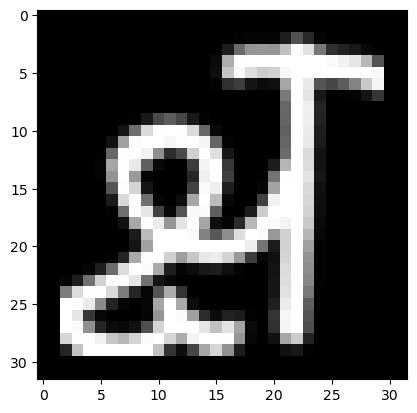

Predicted value:
४
Actual value:
४


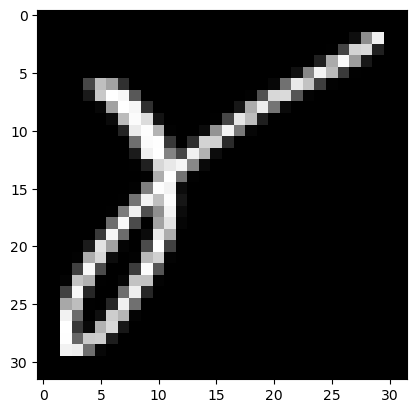

Predicted value:
०
Actual value:
०


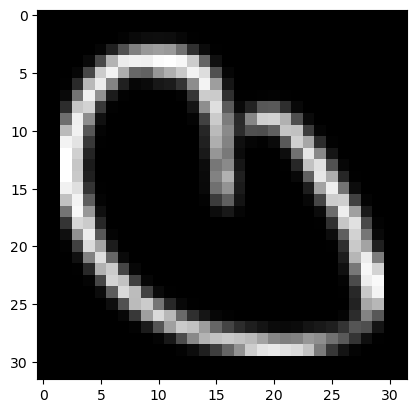

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from dataloader import DHCDataset
from PIL import Image

# Load data using the custom DHCDataset
dataManager = DHCDataset('./dataset/dataset.npz')

# Extract the training and test data
train = dataManager.image_train
train_label = dataManager.label_train
test = dataManager.image_test
test_label = dataManager.label_test

# Decrement the labels by 1 to start from 0
train_label -= 1
test_label -= 1

# Normalize and reshape the data
train = train.reshape(78200, 1024).T / 255.
test = test.reshape(13800, 1024).T / 255.

# Convert data to PyTorch tensors and move to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train = torch.tensor(train, dtype=torch.float32).to(device)
train_label = torch.tensor(train_label, dtype=torch.long).to(device)
test = torch.tensor(test, dtype=torch.float32).to(device)
test_label = torch.tensor(test_label, dtype=torch.long).to(device)

class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(1024, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, 46)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = NeuralNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def accuracy(predictions, labels):
    _, preds = torch.max(predictions, 1)
    return (preds == labels).sum().item() / labels.size(0)

# Training loop
for epoch in range(10000):
    optimizer.zero_grad()
    outputs = model(train.T)
    loss = criterion(outputs, train_label)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        acc = accuracy(outputs, train_label)
        print(f'Epoch {epoch}, Accuracy: {acc * 100:.2f}%')

# Testing function
def test_result():
    with torch.no_grad():
        outputs = model(test.T)
        acc = accuracy(outputs, test_label)
        print(f'Test Accuracy: {acc * 100:.2f}%')

test_result()

# Function to display prediction and actual value
def inNepali(val):
    words = ['क', 'ख', 'ग', 'घ', 'ङ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध', 'न', 'प', 'फ', 'ब', 'भ', 
             'म', 'य', 'र', 'ल', 'व', 'श', 'ष', 'स', 'ह', 'क्ष', 'त्र', 'ज्ञ', '०', '१', '२', '३', '४', '५', '६', '७', '८', '९']
    print(words[int(val)])

def trial(index):
    current_image = train[:, index].unsqueeze(1).T
    with torch.no_grad():
        output = model(current_image)
    prediction = torch.argmax(output, 1).item()
    print("Predicted value:")
    inNepali(prediction)
    print("Actual value:")
    inNepali(train_label[index].item())

    # Draw the image
    image = train[:, index].cpu().numpy().reshape((32, 32)) * 255
    plt.gray()
    plt.imshow(image, interpolation='nearest')
    plt.show()

trial(2434)
trial(17834)
trial(29991)

Adam optimizer rocked my world. How would you be able to able to achieve such levels of accuracy when it takes an equivalent 50000 iterations in the SGD. The performance for training set is unmatched in the comparison of Adam and SGD but test set accuracy is still a thing of question.

28th June, 2024 2:20 pm : I tried using two hidden layers in between each of 100 neurons and that gave a pretty satisfying, your won't believe 100% accuracy result in the training set in the first 3000 iterations. I'm just in state of shock or bliss because of this result. I'm like wow!!! I halted the training because the accuracy was already enough, I just have to see how the new model is able to perform in the test data set. If it's able to cross the 90% obstacle right now, I'll dance like a maniac.

2:23 pm: Yup, it did achieve a 90% accuracy for the test set for the first time ever. Adam optimizer and increasing hidden layers has done wonders for me. Now I need to experiment and see if adding more neurons helps it learn better. I'd probably add two more neurons to it each of 100 neurons. Also, I'd reduce the number of epochs to train because increasing hidden neurons means you can drastically reduce training accuracy for efficiency.

2:29 pm: Nope. It didn't cause any significant improvement after all. The accuracy in both train and test datasets were almost identical to previous iterations which shows its literal insignificance for the purpose as of now.